# Final Workflow

Author: Sofia Ingersoll

Date: 2024 May 20

In [5]:
import xarray as xr
import pickle
from utils import * 
from matplotlib import font_manager

In [6]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)
# apply peer2peer network communication across multiple devices
client.cluster

/glade/u/home/singersoll/.conda/envs/meds-py/lib/python3.11/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 36927 instead
  warnings.warn(


Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/36927/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://128.117.208.103:34683,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/singersoll/proxy/36927/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [9]:
param, var, param_name, var_name = read_n_wrangle('leafcn','GPP','1995-2015')

Reading and wrangling your data, this may take a few minutes


In [24]:
param2, var2, param_name2, var_name2 = read_n_wrangle('leafcn','NBP','1995-2015')

Reading and wrangling your data, this may take a few minutes


In [31]:
param3, var3, param_name3, var_name3 = read_n_wrangle('leafcn','TOTVEGC','1995-2015')

Reading and wrangling your data, this may take a few minutes


In [35]:
param4, var4, param_name4, var_name4= read_n_wrangle('leafcn','TOTVEGC','1995-2015')

In [10]:
var_name

'GPP'

In [154]:
var

<xarray.DataArray 'LNC' (ens: 500)> Size: 4kB
[500 values with dtype=float64]
Dimensions without coordinates: ens

In [157]:
param.shape

(500, 32)

In [11]:
def create_parameter_names_dict():
    data = {
        key.upper(): value for key, value in {
            'FUN_fracfixers': 0, 'KCN': 1, 'a_fix': 2, 'crit_dayl': 3, 'd_max': 4, 'fff': 5,
            'froot_leaf': 6, 'fstor2tran': 7, 'grperc': 8, 'jmaxb0': 9, 'jmaxb1': 10, 'kcha': 11,
            'kmax': 12, 'krmax': 13, 'leaf_long': 14, 'leafcn': 15, 'lmr_intercept_atkin': 16,
            'lmrha': 17, 'lmrhd': 18, 'medlynintercept': 19, 'medlynslope': 20, 'nstem': 21,
            'psi50': 22, 'q10_mr': 23, 'slatop': 24, 'soilpsi_off': 25, 'stem_leaf': 26,
            'sucsat_sf': 27, 'theta_cj': 28, 'tpu25ratio': 29, 'tpuse_sf': 30, 'wc2wjb0': 31
        }.items()
    }
    return data 
    
# object to store in utils outside of any function so it's callable
param_names_dict = create_parameter_names_dict() 

In [93]:
def train_emulator2(param, var, var_name, time_selection):
     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
     # ----         Split Data           ----
     #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var, 
                                                        test_size=0.2,
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Kernel Specs No Tuning
    kernel = ConstantKernel(constant_value=3, constant_value_bounds=(1e-2, 1e4))  \
            * RBF(length_scale=1, length_scale_bounds=(1e-4, 1e8))

    # Using an out-of-the-box kernel for now
    gpr_model = GaussianProcessRegressor(kernel=kernel,
                                         n_restarts_optimizer=20, 
                                         random_state=99, 
                                         normalize_y=True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gpr_model.fit(X_train, y_train)

    # Prepare to store results
    results_dict = {
        'X_values': {},
        'y_pred': {},
        'y_std': {},
        'r2': {},
         # save the trained GPR model
        'gpr_model': gpr_model, 
         # save y_test for R^2 later
        'y_test': y_test, 
        'X_test': X_test
       
    }

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Iterate thru Params     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    for param_name, param_index in param_names_dict.items():
        # Create X_values for prediction linspace
        X_values = np.full((100, len(param_names_dict)), 0.5)           # r2 drops to 0.004 when removing this, but we're only using the R^2 used in fast plot
       # X_values = np.tile(X_test, 1)
        X_values[:, param_index] = np.linspace(0, 1, 100)
        # Vary only the current parameter over a linspace
        #X_values[:, param_index] = np.linspace(np.min(X_test[:, param_index]), np.max(X_test[:, param_index]))

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----         Get Predictions      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Make predictions for the current parameter
        y_pred, y_std = gpr_model.predict(X_values, return_std=True)

        
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----         Collect Metrics      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        mae = mean_absolute_error(y_test, y_pred)
        rmse_emulator = np.sqrt(mean_squared_error(y_test, y_pred))
        r2_emulator = np.corrcoef(y_test, y_pred)[0, 1]**2

        # Store results in dictionaries
        results_dict['X_values'][param_name] = X_values
        results_dict['y_pred'][param_name] = y_pred
        results_dict['y_std'][param_name] = y_std
        results_dict['r2'][param_name] = r2_emulator
        
   
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Pickle Emulation     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # Save the predictions and overall R^2 to a file
        filename = os.path.join("emulation_results", f"{var_name}_{param_name}_{time_selection}_gpr_model.sav")

        if os.path.exists(filename):
            # Load the model from disk
            loaded_model = pickle.load(open(filename, 'rb'))
        else:
            print(f"Emulator is running for {param_name}, this may take a few moments")
            with open(filename, 'wb') as file:
                pickle.dump((X_values, y_pred, y_std, r2_emulator, param_name, var_name), file)

    return results_dict

In [94]:
results_dict = train_emulator2(param4, var4, var_name4, '1995-2015')

In [162]:
#results_dict['y_pred']
#results_dict['y_std']
results_dict['gpr_model']

GaussianProcessRegressor(kernel=1.73**2 * RBF(length_scale=1),
                         n_restarts_optimizer=20, normalize_y=True,
                         random_state=99)

# Need one plotting function to make subplots


In [69]:
def find_global_y_limits(results_dict):
    global_min, global_max = float('inf'), float('-inf')
    for param_name in results_dict['X_values'].keys():
        y_pred = results_dict['y_pred'][param_name]
        y_std = results_dict['y_std'][param_name]
        global_min = min(global_min, np.min(y_pred - y_std))
        global_max = max(global_max, np.max(y_pred + y_std))
    return global_min, global_max

In [95]:
global_min, global_max = find_global_y_limits(results_dict)

In [106]:
def plot_emulator2(results_dict, var_name, param_name, param_names_dict, time_selection, global_min, global_max):
    # Convert param_name to uppercase to match the filenames
    param_name_upper = param_name.upper()
    
    # Retrieve the data for the specific parameter
    X_values = results_dict['X_values'][param_name_upper]
    y_pred = results_dict['y_pred'][param_name_upper]
    y_std = results_dict['y_std'][param_name_upper]

    # Get the parameter index corresponding to the name
    indexed_param = param_names_dict[param_name_upper]

    # Calculate the z-score for the 99.7% confidence interval
    z_score = norm.ppf(0.99865)

    # Plot the results
    plt.figure(figsize=(10, 6))
  
    # Load the Roboto font
    plt.rcParams['font.family'] = 'Roboto'

    # Set the style to a dark theme
    plt.style.use('dark_background')
    plt.plot(X_values[:, indexed_param],
             y_pred,
             color='white',
             linewidth=3,
             label='GPR Prediction')

    # Apply z-score for 99.7% CI
    plt.fill_between(X_values[:, indexed_param],
                     y_pred - z_score * y_std, y_pred + z_score * y_std,
                     alpha=0.5,
                     color='#62c900ff',
                     label='3 St.Dev., Confidence Interval')

    plt.xlabel(f'Perturbed Parameter: {param_name.title()}', size=18)
    plt.ylabel(f'Climate Variable: {var_name.split("_")[0].title()}', size=18)
    plt.title(f'Parameter Perturbation Uncertainty Estimation \nAssessing Global Annual Means {time_selection}', size=24)

    plt.legend(fontsize=16)

    plt.tick_params(axis='both', which='major', labelsize=14)

    # Set y limits based on global min and max
    plt.ylim(global_min, global_max)

    # Save the plot as a PNG file
    plot_dir = 'plots/emulator'
    os.makedirs(plot_dir, exist_ok=True)
    plt.savefig(os.path.join(plot_dir, f'emulator_plot_{var_name}_{param_name_upper}_{time_selection}_gpr_model.png'))

    plt.tight_layout()
    plt.show()

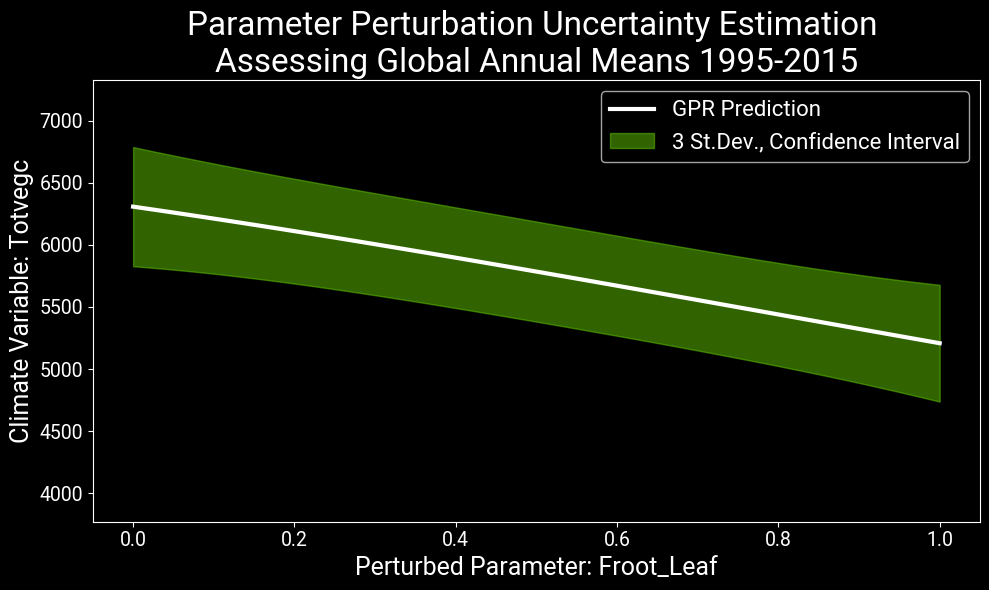

In [107]:
plot_emulator2(results_dict, var_name4, param_name4, param_names_dict, '1995-2015', global_min, global_max)

In [140]:
def plot_FAST_accuracy(results_dict, var_name, param_name, time_selection):
    # Convert param_name to uppercase to match the filenames
    param_name_upper = param_name.upper()
    
    # Retrieve the gpr_model from results_dict
    gpr_model = results_dict['gpr_model']
    # Retrieve the data for the specific parameter
    y_pred = results_dict['y_pred'][param_name_upper]
    y_std = results_dict['y_std'][param_name_upper]
    y_test = results_dict['y_test']

    # Retrieve unweighted X_test to make new predictions
    X_test = results_dict['X_test']

    # Make new predictions with unweighted parameter data
    y_pred_full = gpr_model.predict(X_test)

    # Calculate new r² score
    r2_emulator = r2_score(y_test, y_pred_full)

    def gaussian_regression_lines(gpr_model):
        fourier_amplitudes = []
        
        for param_index in range(32):
            X_values = np.full((10, 32), 0.5)
            X_values[:, param_index] = np.linspace(0, 1, 10)
            y_pred, y_std = gpr_model.predict(X_values, return_std=True)
            y_fft = fft(y_pred)
            amplitude = np.abs(y_fft)
            fourier_amplitudes.append(amplitude[1])

        return fourier_amplitudes

    fourier_amplitudes = gaussian_regression_lines(gpr_model)
    sorted_indices = np.argsort(fourier_amplitudes)
    sorted_fourier_amplitudes = np.array(fourier_amplitudes)[sorted_indices]
    swapped_param_keys = {v: k for k, v in create_parameter_names_dict().items()}
    sorted_parameter_names = [swapped_param_keys[index] for index in sorted_indices]

    fig, ax = plt.subplots(figsize=(16, 8))
    
    # Load the Roboto font
    plt.rcParams['font.family'] = 'Roboto'

    ax.barh(range(len(sorted_fourier_amplitudes)), sorted_fourier_amplitudes, color='#62c900ff', alpha=0.5)
    
    ax.set_ylabel('')
    ax.set_xlabel('Fourier Amplitude Sensitivity Test (FAST)', size = 18)
    ax.set_title(f'Parameter Sensitivty Analysis for {var_name}', size = 24, weight='bold')
    
    ax.set_yticks(range(len(sorted_fourier_amplitudes)), sorted_parameter_names)
    ax.grid(axis='x', linestyle='--', alpha=0.7)
    ax.set_aspect('auto', adjustable='box')

    # Create inset for accuracy plot
    ax_inset = inset_axes(ax, width="40%", height="40%", loc='center right')
    ax_inset.errorbar(y_test, y_pred_full, yerr=3*y_std, fmt="o", color='#62c900ff', alpha=0.5)
    ax_inset.plot([0, np.max(y_test)], [0, np.max(y_pred_full)], linestyle='--', color='white')
    
    ax_inset.set_xlim([np.min(y_test)-1, np.max(y_test)+1])
    ax_inset.set_ylim([np.min(y_pred_full)-1, np.max(y_pred_full)+1])
    
    ax_inset.set_xlabel(f'{var_name} Test', size=16)
    ax_inset.set_ylabel(f'Emulated Variable: {var_name}', size = 16)
    ax_inset.set_title(f'Emulator Accuracy: {var_name} vs {param_name}\nAssessing Global Annual Means {time_selection}', size = 18, weight='bold')
    
    ax_inset.text(0.5, 0.1, f'R² Score = {np.round(r2_emulator, 2)}', fontsize = 12, \
                  transform=ax_inset.transAxes, horizontalalignment='center', weight='bold')
    
    # Save the plot as a PNG file
    plot_dir = 'plots/fast_accuracy'
    os.makedirs(plot_dir, exist_ok=True)
    plt.savefig(os.path.join(plot_dir, f'fast_acc_plot_{var_name}_{param_name}.png'))

   # plt.tight_layout()
    return plt.show()

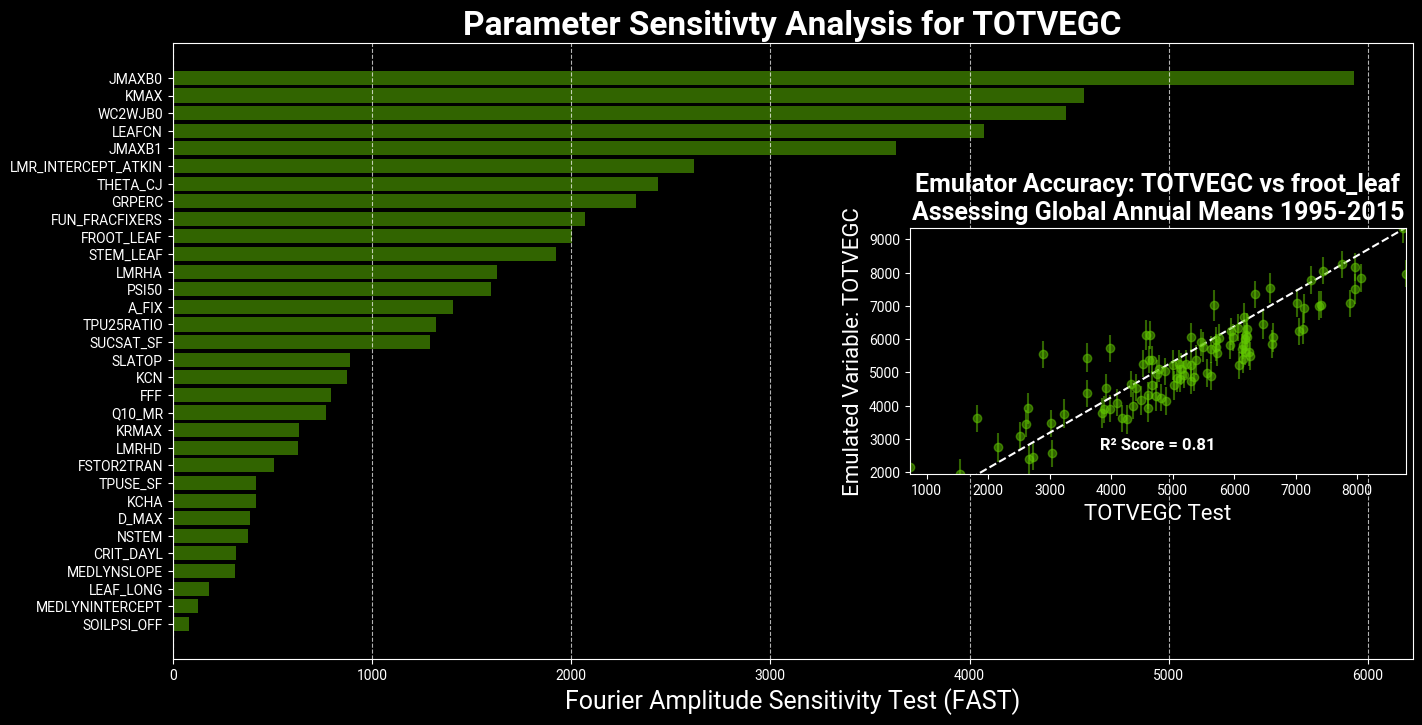

In [141]:
plot_FAST_accuracy(results_dict, var_name4, param_name4, '1995-2015')